# Material added
this notebook contains a study on NMF method. So, I will add some visualization and analytical methods. 
# Clustering text

See also https://towardsdatascience.com/nmf-a-visual-explainer-and-python-implementation-7ecdd73491f8


This notebook uses a collection of clinical case reports to cluster words by topics using the NMF method. To cluster text we need to preprocess the text first with regular natural language processing cleaning steps such as remove punctuations, stopwords, or other unwanted text. we lower the text and use the lemma to reduce variation of words. This is all done in part A. 

Next we need to prepare the text in a document term matrix so that NMF can perform the calculations. The Document-Term Matrix (DTM) represents the frequency of words (or terms) in a collection of documents. Each row in the matrix represents a document, and each column represents a word in the vocabulary. The value in each cell represents the frequency of the corresponding word in the corresponding document. This is done in part B

Lastly we run the clustering algorithm and visualize the outcome. This is done in part C


## The data 
A collection of 200 clinical case report documents in plain text format are used. The documents are named using PubMed document IDs, and have been edited to include only clinical case report details. The dataset is called "MACCROBAT2020" and is the second release of this dataset, with improvements made to the consistency and format of annotations
https://figshare.com/articles/dataset/MACCROBAT2018/9764942


## Portfolio assignment

You can use this assignment to fill your portfolio.
Read, execute and analyse the code in the notebook. Then *choose one* of the assignments a), b) or c). 

a) read the article Clinical Documents Clustering Based on Medication/Symptom Names Using Multi-View Nonnegative Matrix Factorization. you can find the article <a href = 'https://pubmed.ncbi.nlm.nih.gov/26011887/'> here</a>. Explain the similarities of this notebook and the article. Explain in your own words what need to be added to this notebook to reproduce the article. There is no need to code the solution.

b) Improve the outcome improving the data preprocessing and the hyper parameter configurations. Explain your choices. Your solution should be a coded solution with comments. Are there any other weighting solutions next to TF-IDF?

c) Provide a text clustering solution with your own data of interest, for instance text you work with in your project. 

Mind you that you are not allowed to copy code solutions without referencing. 

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction import text
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
import re
import os
import string
import glob
import pandas as pd
import numpy as np
# Slicing dictionaries
import itertools
from pathlib import Path

# Analyzing and Visualizing modules
import matplotlib.pyplot as plt
from wordcloud import WordCloud


In [2]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to C:\Users\Parsian
[nltk_data]     computer\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Part A: get and clean the text

## Get the data

In [3]:
os.chdir('D:\\Data Science for Life Science\\Machine Learning and Deep learning\\Data\\Data')

In [4]:
#create empty dataframe
df = pd.DataFrame(columns=['docid','text'])

# get all files' names ending with .txt
docs = [x for x in glob.glob("*.txt")]

#fill dataframe
for doc in docs:
    txt = Path(doc).read_text()
    df.loc[len(df.index)] = [doc[:-4], txt]

#set index docid
df = df.set_index('docid')

In [5]:
df.head()

,text
docid,
15939911,CASE: A 28-year-old previously healthy man pre...
16778410,The patient was a 34-yr-old man who presented ...
17803823,A 23 year old white male with a 4 year history...
18236639,A 30-year-old female (65 kg) underwent rhinopl...
18258107,"Here, we describe another case in a 60-year-ol..."


## Cleaning the text

The code below defines a function called clean_text that takes a text parameter and returns a cleaned version of it. The function first converts the text to lowercase using the `lower()` method. It then removes any text enclosed in square brackets using **regular expressions** and the re.sub() method. Next, it removes any **punctuation** from the text using the `string.punctuation` module and `re.escape()` and `re.sub()` methods. It then removes any words that **contain numbers** using `re.sub()` and a regular expression. Finally, it removes any **read errors** (represented by the � character) using `re.sub()`.

The code then defines a lambda function called cleaned that takes a single parameter `x` and applies the `clean_text` function to it. This lambda function can be used to clean text data in a Pandas dataframe or any other data structure that can take a lambda function

In [6]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, 
    remove punctuation, remove read errors,
    and remove words containing numbers.'''
    text = text.lower()
    # replace anything that exists in a square bracket with space
    text = re.sub('\[.*?\]', ' ', text)
    # %s means its a string, %d is an integer, %f is floating point number.
    # escape is a function that escapes any special characters present in the the string.
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    # '\w*\d\w*' is a regular expression pattern that matches any word that contains at least one digit.
    text = re.sub('\w*\d\w*', ' ', text)
    # replace the errors with space
    text = re.sub('�', ' ', text)
    return text

cleaned = lambda x: clean_text(x)

The function 'nouns' cleans a text and extracts only the nouns from it. It first defines a lambda function called 'is_noun' that checks if a given word is a noun, based on its part of speech (POS) tag. The input text is then tokenized using the `word_tokenize` function from the **nltk** module, which breaks down the text into smaller units called tokens. Tokenization is an important pre-processing step in NLP that helps standardize and prepare text data for further analysis.

The function creates a `WordNetLemmatizer` object from the nltk module to lemmatize each word, which is the process of converting a word to its base or dictionary form. Lemmatization helps to reduce the dimensionality of text data and improve the accuracy of the analysis, especially in cases where words have different inflected forms but share the same root.

The function uses a list comprehension to lemmatize each word in the tokenized text if it is a noun, and stores the resulting list of lemmatized nouns in the 'all_nouns' variable. Finally, the function returns a string containing the joined list of lemmatized nouns.

Note that this function requires the 'nltk' module to be imported and assumes that the 'pos_tag' function from the 'nltk' module is available.

In [7]:
# Noun extract and lemmatize function
def nouns(text):
    '''Given a string of text, tokenize the text 
    and pull out only the nouns.'''
    # create mask to isolate words that are nouns
    is_noun = lambda pos: pos[:2] == 'NN'
    # store function to split string of words 
    # into a list of words (tokens)
    tokenized = word_tokenize(text)
    # store function to lemmatize each word
    wordnet_lemmatizer = WordNetLemmatizer()
    # use list comprehension to lemmatize all words 
    # and create a list of all nouns
    all_nouns = [wordnet_lemmatizer.lemmatize(word) \
    for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    
    #return string of joined list of nouns
    return ' '.join(all_nouns)


In [8]:

# Clean Text
df["text"] = df["text"].apply(cleaned)
data_nouns = pd.DataFrame(df["text"].apply(nouns))
# Visually Inspect
data_nouns.head()

,text
docid,
15939911,case year man week history palpitation symptom...
16778410,patient man complaint fever cough smoker histo...
17803823,year male year history crohn disease day histo...
18236639,year female kg rhinoplasty anaesthesia combina...
18258107,case year man francisco pork philippine june m...


# Part B: The Document-Term Matrix (DTM)

To perform analyses we need to create a Document-Term Maxtrix. 
The Document-Term Matrix (DTM) represents the frequency of words (or terms) in a collection of documents. Each row in the matrix represents a document, and each column represents a word in the vocabulary. The value in each cell represents the frequency of the corresponding word in the corresponding document.

In specific case below, the DTM has been created using only the nouns extracted from the original text, and has been transformed using the TF-IDF (Term Frequency-Inverse Document Frequency) weighting scheme. The TF-IDF scheme assigns weights to words based on how often they appear in a document relative to how often they appear in the entire corpus. Words that appear frequently in a document but infrequently in the corpus are given higher weights, as they are considered to be more important for distinguishing that document from others in the corpus. This weighting scheme is commonly used in text mining and information retrieval to identify key terms or topics in a collection of documents.

The resulting DTM can be used for various purposes such as topic modeling, clustering, classification, and visualization of text data.

#### TfidfVectorizer: 
This vectorizer will tokenize the text, filter out English stop words, compute the TF-IDF (Term Frequency-Inverse Document Frequency) representation, and only include terms that meet the specified document frequency thresholds. It will consider only unigrams and exclude terms that appear in more than 80% of the documents or less than 1% of the documents

#### stop_words=text.ENGLISH_STOP_WORDS:
This parameter specifies the stop words to be used for filtering during the vectorization process. The value text.ENGLISH_STOP_WORDS suggests that the stop words from the text module in scikit-learn are being used. These are commonly used English words that are often considered insignificant for analysis purposes and are typically excluded from text processing tasks.

#### ngram_range:
An n-gram is a contiguous sequence of n items from a given sample of text. In the context of text processing, an item can be a word or a character. The ngram_range parameter allows you to control the range of n-grams that will be generated from the text data.

The ngram_range parameter takes a tuple as its value, with two elements: (min_n, max_n). Here's what each element represents

    min_n: It specifies the minimum value of n for the range of n-grams. This means that the minimum number of consecutive items (words or characters) to be considered is min_n.
    
    max_n: It specifies the maximum value of n for the range of n-grams. This means that the maximum number of consecutive items (words or characters) to be considered is max_n.

By adjusting the ngram_range parameter, you can control the level of granularity and contextual information captured in the n-grams during the text vectorization process.

#### max_df=0.8: 
This parameter sets the maximum document frequency for a term to be included in the vectorization. A value of 0.8 means that any term that appears in more than 80% of the documents will be ignored.

#### min_df=0.01:
 This parameter sets the minimum document frequency for a term to be included in the vectorization. A value of 0.01 means that a term must appear in at least 1% of the documents to be considered.

In [9]:
# Create a document-term matrix with only nouns
# Store TF-IDF Vectorizer
tv_noun = TfidfVectorizer(stop_words=text.ENGLISH_STOP_WORDS, ngram_range = (1,1), max_df = .8, min_df = .01)
# Fit and Transform speech noun text to a TF-IDF Doc-Term Matrix
data_tv_noun = tv_noun.fit_transform(data_nouns.text)
# Create data-frame of Doc-Term Matrix with nouns as column names
# first it changes the data_tv_noun to an array and then use the nouns exist in tv_noun as the columns of the dataset
data_dtm_noun = pd.DataFrame(data_tv_noun.toarray(), columns=tv_noun.get_feature_names_out())
data_dtm_noun.index = df.index
# Visually inspect Document Term Matrix
data_dtm_noun.head()

,abdomen,ablation,abnormality,abscess,absence,absent,abuse,access,accompanying,accordance,...,york,yr,zhejiang,zinc,zone,µg,µmol,μg,μl,μmol
docid,,,,,,,,,,,,,,,,,,,,,
15939911,0.000000,0.408857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
16778410,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
17803823,0.057677,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
18236639,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.243491,0.000000,0.0
18258107,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.113573,0.0


# Part C: Run the NMF

This code below performs Non-negative Matrix Factorization (NMF) on the Document Term Matrix (DTM) with only nouns. NMF is a dimensionality reduction technique that decomposes a matrix into two matrices: a document-topic matrix (W) and a topic-term matrix (H).

The code first creates an NMF model with 5 topics. The model is then fit to the DTM with the fit_transform() method, which returns the document-topic matrix (W).

The `display_topics()` function is called to extract the top words from the topic-term matrix (H) using the feature names from the TF-IDF vectorizer. 

The resulting output will show the top n words for each of the n topics learned by the NMF model.

In [10]:
def display_topics(model, feature_names, num_top_words, topic_names=None):
    '''Given an NMF model, feature_names, and number of top words, print 
       topic number and its top feature names, up to specified number of top words.'''
    # iterate through topics in topic-term matrix, 'H' aka
    # model.components_
    for ix, topic in enumerate(model.components_):
        #print topic, topic number, and top words
        # if there is no topic or term print
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        # print topics and their most frequent words
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i] \
             for i in topic.argsort()[:-num_top_words - 1:-1]]))

In [74]:
nmf_model = NMF(5)
# Learn an NMF model for given Document Term Matrix 'V' 
# Extract the document-topic matrix 'W'
doc_topic = nmf_model.fit_transform(data_dtm_noun)
# Extract top words from the topic-term matrix 'H' 
display_topics(nmf_model, tv_noun.get_feature_names_out(), 10)


Topic  0
dl, mg, level, blood, ml, day, count, platelet, serum, range

Topic  1
tumor, mass, cell, cm, lesion, figure, fig, lymph, resection, metastasis

Topic  2
valve, figure, echocardiography, heart, artery, mm, pressure, failure, atrium, vein

Topic  3
lung, day, chest, fig, treatment, hospital, tuberculosis, therapy, effusion, dyspnea

Topic  4
age, month, eye, week, seizure, rash, parent, mri, muscle, brain


c:\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


For inspiration of visualizations see https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

# Visualization and Analytical Methods:

### Word Clouds:
A tag cloud (also known as a word cloud, wordle or weighted list in visual design) is a visual representation of text data which is often used to depict keyword metadata on websites, or to visualize free form text. Tags are usually single words, and the importance of each tag is shown with font size or color. When used as website navigation aids, the terms are hyperlinked to items associated with the tag. [Wiki]

https://en.wikipedia.org/wiki/Tag_cloud

In this study, I will use wordcloud library

https://pypi.org/project/wordcloud/

In [75]:
def dictionary_maker(keys, values, order=1, slice_number=False):

    # making the dictionary of words with their magnitude in each topic
    dictionary = {}
    for counter, key in enumerate(keys):
        dictionary[key] = values[counter]
    
    # sort the dictionary in an ascending or descending order
    dictionary = dict(sorted(dictionary.items(), key=lambda item: order * item[1]))

    # slice the dictionary if needed
    if slice_number != False:
        dictionary = dict(itertools.islice(dictionary.items(), slice_number))
    
    return dictionary

In [76]:
def worldcloud_plot_maker(df, word_list, title_list=[], order=-1, row_column=0, color_map='magma'):
    # sketch the main plot
    fig = plt.figure(figsize=(10, 18.6))
    plot_number = df.shape[row_column]

    for number in range(plot_number):
        # sketch the sub-plot
        fig.add_subplot(plot_number,1,number+1)

        if len(title_list) == 0:
            plt.title(f'topic{number+1}', fontsize=15)        
        else:
            plt.title(title_list[number],fontsize=15)

        if row_column == 0:
            dictionary = dictionary_maker(word_list, df[number, :], order=order)
        else:
            dictionary = dictionary_maker(word_list, df[:, number], order=order)

        wordcloud = WordCloud(background_color='white',  colormap=color_map)
        wordcloud.generate_from_frequencies(dictionary) 
        
        plt.imshow(wordcloud, interpolation="bilinear")

        plt.axis("off")
    
        plt.show()


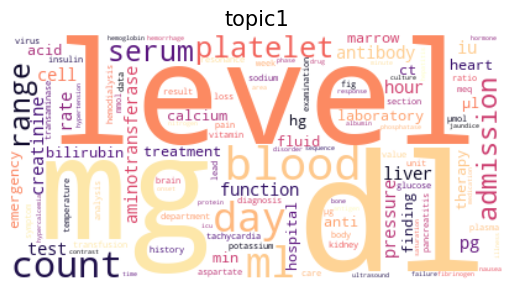

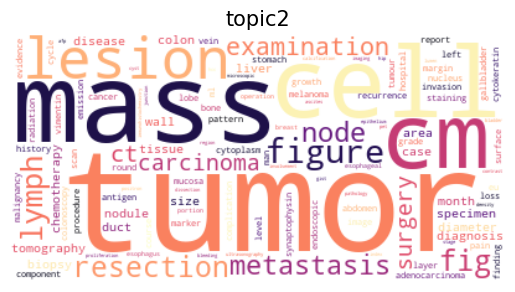

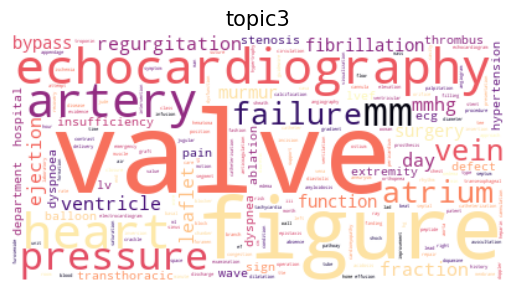

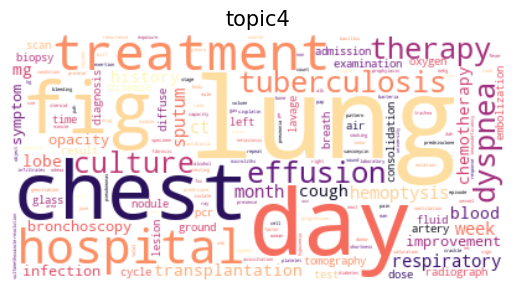

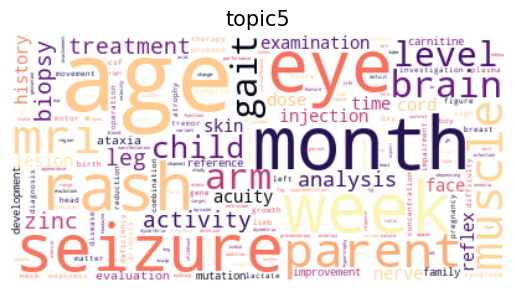

In [77]:
worldcloud_plot_maker(nmf_model.components_, tv_noun.get_feature_names_out())

By utilizing these functions, it becomes possible to visually identify the most frequently occurring words within each topic. In this specific scenario, employing five topics suffices, as additional topics would result in the fragmentation of overarching themes into smaller clusters. Consequently, multiple topics would emerge with similar meanings. Opting for fewer than five topics would not adequately encompass all subjects within the dataset. Hence, five proves to be the optimal number of topics. Furthermore, it is possible to assign names to these topics. However, it is important to acknowledge that these names are subjective and subject to individual interpretation. Thus, another person may assign similar yet distinct names to the topics.

names:
A) topic1: Labratory Measurement

B) topic2: Cancer

C) topic3: Heart Diseases

D) topic4:Lung Diseases

E) topic5: Personal Information